# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
This first block of code is the functions that support the actual work. The executable blocks are in lower cells.

The two functions with the majority of my code are process_image and drawLines.

drawLines() existed before, but was updated to average-together all of the left-lane-lines and right lane-lines, then extrapolating each of those lines to fill the full height of the lane.

process_image() applies the whole pipeline of grayscaling, gaussian smoothing, Canny edge-detection, and Hough Transformation (with the averaging and extrapolating of lines).

There are a few lines of code at the end of this block that are used to ensure that the correct directories exist on the filesystem for the output files.

In [10]:
import cv2
from IPython.display import HTML
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
import numpy as np
import operator
import os
%matplotlib inline

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, lane_min_y, lane_max_y, origImg, color=[255, 0, 0], thickness=5):
    """
    Separates line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, averages the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.
    Lines are drawn on the image inplace (mutates the image).
    The results are opaque, transparency is applied (with weighted_img) to the
    results of the hough_lines function.
    """
    
    # If we set too small of a target area, or otherwise poorly tuned our parameters, it's
    # possible that there were no lines found.
    if lines is None:
        return
    
    # Identify lines (by slope) as being left or right lane-lines, and find
    # an average of the high and low points to create an average line for each
    # lane.
    numLeftLines = 0
    lowLeftTotals = [0, 0]
    highLeftTotals = [0, 0]
    numRightLines = 0
    lowRightTotals = [0, 0]
    highRightTotals = [0, 0]
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1))
            if(slope < 0): # since y value is at bottom of image, negative slope is left lane lines
                #print("Left slope: ",slope)
                numLeftLines += 1
                if(x1 < x2):
                    lowLeftTotals = list(map(operator.add, lowLeftTotals, [x1, y1]))
                    highLeftTotals = list(map(operator.add, highLeftTotals, [x2, y2]))
                else:
                    lowLeftTotals = list(map(operator.add, lowLeftTotals, [x2, y2]))
                    highLeftTotals = list(map(operator.add, highLeftTotals, [x1, y1]))
            elif(slope > 0):
                #print("Right slope: ",slope)
                numRightLines += 1
                if(x1 < x2):
                    highRightTotals = list(map(operator.add, highRightTotals, [x1, y1]))
                    lowRightTotals = list(map(operator.add, lowRightTotals, [x2, y2]))
                else:
                    highRightTotals = list(map(operator.add, highRightTotals, [x2, y2]))
                    lowRightTotals = list(map(operator.add, lowRightTotals, [x1, y1]))
            else:
                # Horizontal lines (slope = 0) will be ignored.
                continue
                    
    # NOTE: Sometimes at this point, we have found no lines on one or more sides. If that's the case, we just don't
    # draw that line. One other valid approach could be to remember the previous right line and use
    # that... until we've gone X iterations in a row without new information (then throw some exception).
    # This would give us a reasonable approximation of the missing lines on frames that don't have one. For
    # now we just skip drawing the line that doesn't have points.
    #if((numLeftLines ==0)  or (numRightLines == 0)):
        #print("LEFT LINES: ",numLeftLines," RIGHT LINES: ",numRightLines)
        #saveFile = os.path.join(OUT_DIR, "missing_lines_"+str(numLeftLines)+"_"+str(numRightLines)+".jpg") # will keep overwriting the same image
        #plt.imsave(saveFile, origImg)
        #plt.figure()
        #plt.imshow(origImg) # show every image in the notebook for debugging


    # Average all lane-lines to find a representative line for each lane.
    if(numLeftLines > 0):
        lowLeftPoint = list(map(operator.truediv, lowLeftTotals, [numLeftLines,numLeftLines]))
        highLeftPoint = list(map(operator.truediv, highLeftTotals, [numLeftLines,numLeftLines]))
    if(numRightLines > 0):
        lowRightPoint = list(map(operator.truediv, lowRightTotals, [numRightLines,numRightLines]))
        highRightPoint = list(map(operator.truediv, highRightTotals, [numRightLines, numRightLines]))

    # Extrapolate each lane-line to fill the full height of the lane.
    # We will do this by finding the intersection between each lane-line and the lane_min_y (to find top point of line)
    # and the intersection b/w the lane-line and lane_max_y (bottom point of the line).
    if(numLeftLines > 0):
        [lowLeftPoint, highLeftPoint] = extrapolateLineToMinMaxY(lowLeftPoint, highLeftPoint, lane_min_y, lane_max_y)
    if(numRightLines > 0):
        [lowRightPoint, highRightPoint] = extrapolateLineToMinMaxY(lowRightPoint, highRightPoint, lane_min_y, lane_max_y)
    
    # cv2.line requires ints and rounding is more accurate than just casting
    if(numLeftLines > 0):
        lowLeftPoint = [ round(elem) for elem in lowLeftPoint ]
        lowLeftPoint = list(map(int, lowLeftPoint))
        highLeftPoint = [ round(elem) for elem in highLeftPoint ]
        highLeftPoint = list(map(int, highLeftPoint))
    if(numRightLines > 0):
        lowRightPoint = [ round(elem) for elem in lowRightPoint ]
        lowRightPoint = list(map(int, lowRightPoint))
        highRightPoint = [ round(elem) for elem in highRightPoint ]
        highRightPoint = list(map(int, highRightPoint))

    # Draw each averaged-out, extrapolated lane-line. Using the number of lines as the thickness
    if(numLeftLines > 0):
        cv2.line(img, (lowLeftPoint[0], lowLeftPoint[1]), (highLeftPoint[0], highLeftPoint[1]), color, thickness)
    if(numRightLines > 0):
        cv2.line(img, (lowRightPoint[0], lowRightPoint[1]), (highRightPoint[0], highRightPoint[1]), color, thickness)
    
def extrapolateLineToMinMaxY(p1, p2, min_y, max_y):
    """
    Given points p1 and p2, will return new points of a line that go between min_y and max_y. This
    will be used so that our lane-lines are extrapolated to the entire mask-area that we were looking at.
    
    The return-value will be a list containing two lists: one for each point of the new line.
    """
    x1 = p1[0]
    y1 = p1[1]
    x2 = p2[0]
    y2 = p2[1]
    slope = ((y2-y1)/(x2-x1))
    yInterceptOfLine = (y1 - (slope*x1))
    
    # Based on the equation for intersection of a horizontal line and another line (that I derived on paper):
    min_x = ((min_y - yInterceptOfLine) / slope)
    max_x = ((max_y - yInterceptOfLine) / slope)

    return [ [min_x, min_y], [max_x, max_y] ]
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, min_y, max_y):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.  This has been modified from its initial state
    to extrapolate those lines to extend between min_y and max_y (eg: to fill the height of
    the lane).
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, min_y, max_y, img)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


# Given an image (eg: loaded from a file or a video-frame)
# processes it to overlay lane-lines on top of the image
# as semi-transparent red lines. Returns the modified image.
def process_image(image):
    gray = grayscale(image)
    
    # Apply Gaussian smoothing & Canny edge detection
    blur_gray = gaussian_blur(gray, kernel_size=5)

    # Define our parameters for Canny and apply
    edges = canny(blur_gray, low_threshold=100, high_threshold=200)
    
    # == MASK OUT THE TRAPAZOIDAL AREA OF INTEREST ==
    # We're defining a trapazoidal area at the center/bottom of the
    # screen, in which to look. triangleHeight and trapazoidTopWidth are
    # the parameters to manually tune, to control the size of the trapazoid.
    imgshape = image.shape
    imgHeight = imgshape[0]
    imgWidth = imgshape[1]
    triangleHeight = imgHeight * 0.44 # guess/test/revised to tune this number
    trapazoidTopWidth = imgWidth * 0.1 # how wide the top of the trapezoid will be
    xOffset = (trapazoidTopWidth / 2) # dist that trapazoid top points will be from vertical center-line
    # Trig to figure out the points in the trapazoid based on the configuration & image size:
    theta = math.atan( triangleHeight / (imgWidth/2) )
    topLeftX = ( (imgWidth/2) - xOffset )
    topLeftY = imgHeight - (topLeftX * math.tan(theta))
    topRightX = ( (imgWidth/2) + xOffset )
    topRightY = topLeftY

    # We have the points... use the trapezoid as a mask.
    vertices = np.array([[
        (0, imgHeight),
        (topLeftX, topLeftY),
        (topRightX, topRightY),
        (imgWidth, imgHeight)
    ]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # == HOUGH TRANSFORM ==
    # Define the Hough transform parameters - going with recommended
    # weightings used in Lession 1:15.
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 40 #minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap, topLeftY, imgHeight)
    
    # Overlay the hough lines on the original image.
    combined_image = weighted_img(line_image, image)

    # The original image will now be returned with semitransparent lane-lines overlaid on it.
    return combined_image




###############################################################
# SOME EXECUTING CODE FOR SETTING UP DIRECTORIES BEFORE ANY OF THE ACTUAL DATA GENERATION!
IN_DIR = "test_images"
OUT_DIR = "test_images_output"

VIDEO_IN_DIR = "test_videos"
VIDEO_OUT_DIR = "test_videos_output"
if not os.path.exists(VIDEO_OUT_DIR):
    os.makedirs(VIDEO_OUT_DIR)

# Ensure the output directory exists so that we can write to it.
if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)


## Processing Static Images

This section will take images from test_images, find lane lines, and extend them to the full
considered size of the lane.


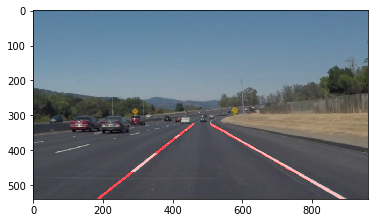

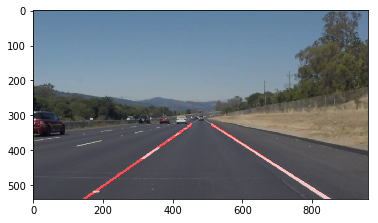

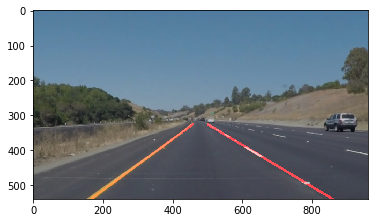

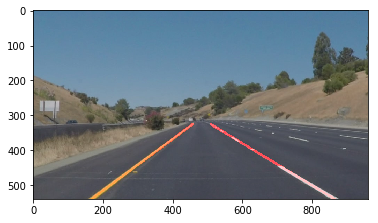

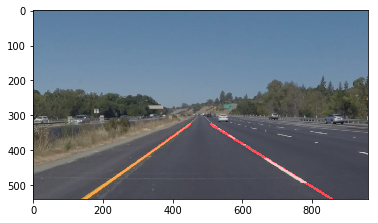

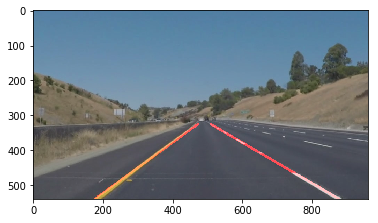

In [11]:
# Process and save each file that exists in the input directory.
files = os.listdir(IN_DIR)
for fileIndex in range(len(files)):
    fullFilePath = os.path.join(IN_DIR, files[fileIndex])
    
    # All of the image-processing is done in this call
    image = mpimg.imread(fullFilePath)
    image = process_image(image)
    
    # Take the processed image and save it to the output directory.
    saveFile = os.path.join(OUT_DIR, files[fileIndex])
    plt.imsave(saveFile, image)
    
    # The files are already saved... also show the image in the notebook.
    plt.figure()
    plt.imshow(image)

## Solid White Right-line Video

Below will generate the video with the solid right lane-line:


In [12]:
white_input = os.path.join(VIDEO_IN_DIR, 'solidWhiteRight.mp4')
white_output = os.path.join(VIDEO_OUT_DIR, 'solidWhiteRight.mp4')
clip1 = VideoFileClip(white_input)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
#%time white_clip.write_videofile(white_output, audio=False)
white_clip.write_videofile(white_output, audio=False)

#Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video test_videos_output\solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output\solidWhiteRight.mp4


100%|███████████████████████████████████████▊| 221/222 [00:02<00:00, 70.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output\solidWhiteRight.mp4 



## Solid Yellow Left-line Video

Below will generate the video with the solid left line:

In [13]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████▉| 681/682 [00:08<00:00, 75.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 9.46 s


## Optional Challenge

This code currently doesn't work well on the Challenge video. I assume that instead of fitting straight-lines to the points, we'll have to do a best-fit of a curve.

In [14]:

# === CHALLENGE ===
# My algorithm doesn't work well for the challenge. Perhaps best-fit curve would be better
# than lines.
challenge_output = 'test_videos_output/challenge.mp4'
clip2 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

# It's embarassing! Don't display it yet ;)
#HTML("""
#<video width="960" height="540" controls>
#  <source src="{0}">
#</video>
#""".format(challenge_output))



[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|████████████████████████████████████████| 251/251 [00:06<00:00, 37.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 7.69 s
